# basic model


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, MaxPooling2D, Concatenate, Add, Conv2D, Subtract, Multiply, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.metrics import MeanIoU
from collections import Counter
from sklearn.metrics import classification_report

import os
import numpy as np
import cv2


In [2]:
depth_folder = './train/depth'
rgb_folder = './train/image'
segmentation_label_folder = './train/label'

depth_files = sorted(os.listdir(depth_folder))
rgb_files = sorted(os.listdir(rgb_folder))
segmentation_label_files = sorted(os.listdir(segmentation_label_folder))

assert len(depth_files) == len(rgb_files) == len(segmentation_label_files), "Mismatch in file counts across folders."

# Load the data
data = []
class_frequencies = Counter()
total_pixels = 0
for i in range(len(depth_files)):
    depth_path = os.path.join(depth_folder, depth_files[i])
    rgb_path = os.path.join(rgb_folder, rgb_files[i])
    seg_label_path = os.path.join(segmentation_label_folder, segmentation_label_files[i])

    depth_img = np.load(depth_path)
    rgb_img = np.load(rgb_path)
    seg_label = np.load(seg_label_path)

    unique_classes, counts = np.unique(seg_label, return_counts=True)
    class_frequencies.update(dict(zip(unique_classes, counts)))
    total_pixels += seg_label.size

    data.append((depth_img, rgb_img, seg_label))

import matplotlib.pyplot as plt



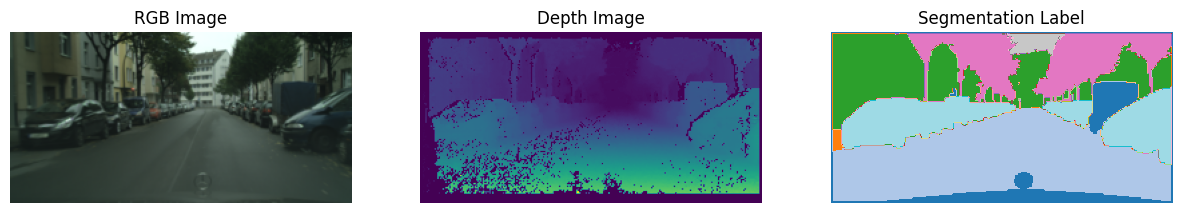

In [3]:
depth_img, rgb_img, seg_label = data[15]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot RGB image
axes[0].imshow(rgb_img)
axes[0].set_title('RGB Image')
axes[0].axis('off')

# Plot Depth image
axes[1].imshow(depth_img, cmap='viridis')
axes[1].set_title('Depth Image')
axes[1].axis('off')

# Plot Segmentation Label
axes[2].imshow(seg_label, cmap='tab20')
axes[2].set_title('Segmentation Label')
axes[2].axis('off')

plt.show()

In [4]:


sorted(list(class_frequencies.keys()))
for val in class_frequencies.keys():
    print(val)
print('\n')
for val in class_frequencies.values():
    print((val/total_pixels)*100)
print('\n')
print(len(class_frequencies.keys()))


-1.0
0.0
1.0
2.0
5.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
18.0
3.0
4.0
6.0
17.0
14.0
15.0
16.0


12.24624249113708
32.443010346228334
5.306801675748424
20.041927049139968
1.079105409253545
0.47479581432182244
13.955929539784664
1.0102600610556722
3.5450206083409928
1.033653451615021
0.12014180672268908
6.146646707999606
0.35745444418001576
0.5598603577173057
0.7466766613872111
0.18001011439732142
0.0892754562762605
0.24162100142791493
0.21222539308692226
0.20934161017922792


20


In [5]:
seg_label = data[0][2]

# Get unique classes in the segmentation label
unique_classes = np.unique(seg_label)
num_classes = len(unique_classes)
print(f"Unique classes in segmentation label: {unique_classes}")
print(f"Number of segmentation classes: {num_classes}")
print(to_categorical(seg_label).shape)

Unique classes in segmentation label: [-1.  0.  1.  2.  5.  7.  8.  9. 10. 11. 12. 13. 18.]
Number of segmentation classes: 13
(128, 256, 19)


In [6]:
rgb_dir = './train/image'
label_dir = './train/label'
depth_dir = './train/depth'

rgb_shape = (128, 256, 3)
input_shape = (128, 256, 3)
num_classes = 20
batch_size = 16


class NPYDataGenerator(Sequence):
    def __init__(self, rgb_dir, label_dir, depth_dir, batch_size=8, image_size=(128, 256), num_classes=20, shuffle=True):
        self.rgb_dir = rgb_dir
        self.label_dir = label_dir
        self.depth_dir = depth_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.file_indices = sorted([int(f.split('.')[0]) for f in os.listdir(rgb_dir)])
        self.on_epoch_end()

    def __len__(self):
        return len(self.file_indices) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.file_indices[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_indices)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_indices)

    def __data_generation(self, batch_indices):
        X = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, *self.image_size, 1), dtype=np.int32) # One hot encoded y with 19 channels one for each segmentation class

        for i, idx in enumerate(batch_indices):
            rgb_path = os.path.join(self.rgb_dir, f"{idx}.npy")
            label_path = os.path.join(self.label_dir, f"{idx}.npy")
            
            X[i] = np.load(rgb_path).astype(np.float32) / 255.0                        
            
            # Load label and add 1 to shift labels from -1 (background) to 0 (background) and 1-19 for classes
            y[i] = np.load(label_path).astype(np.int32).reshape((*self.image_size, 1)) + 1
        
        y_one_hot = to_categorical(y, num_classes=num_classes)

        return X, y_one_hot

train_generator = NPYDataGenerator(rgb_dir, label_dir, depth_dir, batch_size=batch_size, image_size=rgb_shape[:2], num_classes=num_classes)

val_rgb_dir = './val/image'
val_label_dir = './val/label'
val_depth_dir = './val/depth'

val_generator = NPYDataGenerator(val_rgb_dir, val_label_dir, val_depth_dir, batch_size=batch_size, image_size=rgb_shape[:2], num_classes=num_classes)

test_rgb_dir = './test/image'
test_label_dir = './test/label'
test_depth_dir = './test/depth'

test_generator = NPYDataGenerator(
    rgb_dir=test_rgb_dir,
    label_dir=test_label_dir,
    depth_dir=test_depth_dir,
    batch_size=batch_size,
    image_size=rgb_shape[:2],
    num_classes=num_classes,
    shuffle=False  
)

In [7]:
def unet(input_shape=(128, 128, 3), num_classes=20):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(512, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(256, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(256, 3, activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(128, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(128, 3, activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(64, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(64, 3, activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(32, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(32, 3, activation='relu', padding='same')(c9)

    # Segmentation output
    segmentation_output = Conv2D(num_classes, 1, activation='softmax', name='segmentation_mask')(c9)

    model = Model(inputs=inputs, outputs=segmentation_output)
    return model

unet_model = unet(input_shape, num_classes)
unet_model.compile(
    optimizer=Adam(),
    loss={
        'segmentation_mask': CategoricalCrossentropy(from_logits=False),
    },
    metrics={'segmentation_mask': 'accuracy'}
)


unet_model.load_weights("./unet.weights.h5")
# unet_history = unet_model.fit(train_generator, validation_data=val_generator, epochs=20, initial_epoch=15)

C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


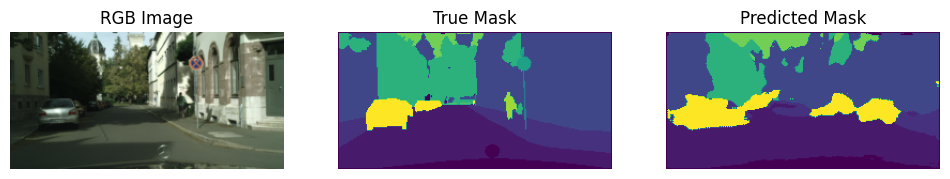

In [8]:
test_rgb_dir = './test/image'
test_label_dir = './test/label'
test_depth_dir = './test/depth'

test_generator = NPYDataGenerator(
    rgb_dir=test_rgb_dir,
    label_dir=test_label_dir,
    depth_dir=test_depth_dir,
    batch_size=batch_size,
    image_size=rgb_shape[:2],
    num_classes=num_classes,
    shuffle=False 
)

val_images, val_labels = test_generator[35]

sample_image = val_images[0]  # This includes RGB, depth, and one-hot label channels
true_label = val_labels[0]  # Ground truth segmentation mask for the main output

predictions = unet_model.predict(np.expand_dims(sample_image, axis=0))

predicted_mask = np.argmax(predictions[0], axis=-1)  # main_segmentation_out is the first output in the list
true_mask = np.argmax(true_label, axis=-1)

# Plot the RGB image, true mask, and predicted mask
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(sample_image[:, :, :3]*255)  # Only take RGB channels
plt.title("RGB Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='viridis')
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='viridis')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [9]:
mean_iou_metric = MeanIoU(num_classes=num_classes)
all_true_masks = []
all_predicted_masks = []
for batch_idx in range(len(test_generator)):
    images, labels = test_generator[batch_idx]

    
    predictions = unet_model.predict(images)
    
    for i in range(len(predictions)):
        predicted_mask = np.argmax(predictions[i], axis=-1)
        
        true_mask = np.argmax(labels[i], axis=-1)

        all_true_masks.extend(true_mask.flatten())
        all_predicted_masks.extend(predicted_mask.flatten())
        
        mean_iou_metric.update_state(true_mask, predicted_mask)

all_true_masks = np.array(all_true_masks)
all_predicted_masks = np.array(all_predicted_masks)

report = classification_report(all_true_masks, all_predicted_masks, labels=range(num_classes), zero_division=0)
print("Classification Report (Precision, Recall, F1 Score per Class):\n", report)

mean_iou = mean_iou_metric.result().numpy()
print(f"Mean IoU on the test set: {mean_iou}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
import pandas as pd
from sklearn.metrics import classification_report

report_dict = classification_report(
    all_true_masks, all_predicted_masks, labels=range(num_classes), zero_division=0, output_dict=True
)

report_df = pd.DataFrame(report_dict).transpose()

report_df.to_excel("./unet_classification_report.xlsx", index=True)

print("Classification report saved to classification_report.xlsx")


Classification report saved to classification_report.xlsx


In [11]:
unet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 128,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 128,   │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 16,     │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 16,     │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 16,     │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 32,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 32,    │          0 │ conv2d_transpose

 Total params: 7,760,724 (29.60 MB)

 Trainable params: 7,760,724 (29.60 MB)

 Non-trainable params: 0 (0.00 B)